In [1]:
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as torch_dist

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed = 0

# set plotting style
strip_size = 12
label_size = 14
mpl.rcParams["axes.labelsize"] = label_size
mpl.rcParams["xtick.labelsize"] = strip_size
mpl.rcParams["ytick.labelsize"] = strip_size
mpl.rcParams["legend.title_fontsize"] = strip_size
mpl.rcParams["axes.titlesize"] = label_size
mpl.rcParams["figure.titlesize"] = label_size

In [3]:
class Gridworld:
    def __init__(
        self,
        num_grids,
        init_pos=np.array([]),
        goal_pos=np.array([]),
        epsilon=0.
        ):
        """
        Args:
            num_grids (int): number of grids per side
            init_post (np.array): initial state positions.
                default is uniform except goal states. size=[n, 2]
            goal_post (np.array): goal state positions. default is upper right. size=[n, 2]
            epsilon (float): transition error. Default=0.
        """
        assert epsilon < 1.
        self.num_grids = num_grids
        self.state_dim = num_grids ** 2
        self.act_dim = 5
        self.a_labels = ["up", "right", "down", "left", "stay"]
        self.epsilon = epsilon

        # state to position mapping
        state2pos = list(itertools.product(np.arange(num_grids), np.arange(num_grids)))
        self.state2pos = np.array(state2pos).reshape(self.state_dim, -1).astype(int)

        # target distribution
        if len(goal_pos) == 0:
            goal_pos = np.array([[num_grids - 1, num_grids - 1]])
        self.goal_states = np.stack([self.pos2state(p) for p in goal_pos])

        self.target_dist = np.zeros(self.state_dim)
        self.target_dist[self.goal_states] = 1./len(self.goal_states)
        self.reward_matrix = np.log(self.target_dist + 1e-6)

        # initial state distribution
        if len(init_pos) == 0:
            init_states = np.ones(self.state_dim)
            init_states[self.goal_states] = 0.
            self.init_states = np.where(init_states == 1)[0]
        else:
            self.init_states = np.stack([self.pos2state(p) for p in init_pos])
        self.init_dist = np.zeros(self.state_dim)
        self.init_dist[self.init_states] = 1./len(self.init_states)

        self.make_transition_matrix()

    def pos2state(self, pos):
        """ Map a single position to state
        Args:
            pos (torch.tensor): size=[n, 2]
        """
        return np.where(np.all(pos == self.state2pos, axis=1))[0]

    def value2map(self, v):
        """ Convert value to grid map """
        num_grids = self.num_grids

        v_map = np.zeros((num_grids, num_grids))
        for i in range(num_grids): # x pos
            for j in range(num_grids): # y pos
                v_map[j, i] = v[self.pos2state(np.array([i, j]))]
        return v_map

    def make_transition_matrix(self):
        # pos [0, 0] is origin
        transition = np.zeros((self.act_dim, self.state_dim, self.state_dim))

        pos = self.state2pos.copy()
        for a in range(self.act_dim):
            next_pos = pos.copy()
            next_error_pos1 = pos.copy()
            next_error_pos2 = pos.copy()


            if a == 0: # up
                next_pos[:, 1] = np.clip(next_pos[:, 1] + 1, 0, self.num_grids - 1)
                next_error_pos1[:, 0] = np.clip(next_error_pos1[:, 0] - 1, 0, self.num_grids - 1)
                next_error_pos2[:, 0] = np.clip(next_error_pos2[:, 0] + 1, 0, self.num_grids - 1)
            elif a == 1: # right
                next_pos[:, 0] = np.clip(next_pos[:, 0] + 1, 0, self.num_grids - 1)
                next_error_pos1[:, 1] = np.clip(next_error_pos1[:, 1] + 1, 0, self.num_grids - 1)
                next_error_pos2[:, 1] = np.clip(next_error_pos2[:, 1] - 1, 0, self.num_grids - 1)
            elif a == 2: # down
                next_pos[:, 1] = np.clip(next_pos[:, 1] - 1, 0, self.num_grids - 1)
                next_error_pos1[:, 0] = np.clip(next_error_pos1[:, 0] - 1, 0, self.num_grids - 1)
                next_error_pos2[:, 0] = np.clip(next_error_pos2[:, 0] + 1, 0, self.num_grids - 1)
            elif a == 3: # left
                next_pos[:, 0] = np.clip(next_pos[:, 0] - 1, 0, self.num_grids - 1)
                next_error_pos1[:, 1] = np.clip(next_error_pos1[:, 1] + 1, 0, self.num_grids - 1)
                next_error_pos2[:, 1] = np.clip(next_error_pos2[:, 1] - 1, 0, self.num_grids - 1)
            elif a == 4: # stay
                pass

            next_states = np.hstack([self.pos2state(next_pos[i]) for i in range(len(next_pos))])
            next_error_states1 = np.hstack(
                [self.pos2state(next_error_pos1[i]) for i in range(len(next_error_pos1))]
            )
            next_error_states2 = np.hstack(
                [self.pos2state(next_error_pos2[i]) for i in range(len(next_error_pos2))]
            )

            # fill in transition probs
            transition[a, np.arange(self.state_dim), next_states] += 1 - self.epsilon
            transition[a, np.arange(self.state_dim), next_error_states1] += self.epsilon/2
            transition[a, np.arange(self.state_dim), next_error_states2] += self.epsilon/2

        self.transition_matrix = transition

    def reset(self, batch_size=1):
        # sample initial state
        self.s = np.random.choice(np.arange(self.state_dim), size=(batch_size,), p=self.init_dist)
        return self.s

    def step(self, a):
        s_dist = self.transition_matrix[a, self.s]
        s_next = torch.multinomial(torch.from_numpy(s_dist), 1).numpy().flatten()
        r = self.reward_matrix[s_next]

        self.s = s_next
        terminated = False
        return s_next, r, terminated, {}


In [4]:
np.random.seed(seed)

num_grids = 5
init_pos = np.array([
    [0, 0],
])
goal_pos = np.array([
    [4, 4],
])
epsilon = 0.

# test env
env = Gridworld(num_grids, init_pos=init_pos, goal_pos=goal_pos, epsilon=epsilon)

In [7]:
def value_iteration(transition, reward, T, gamma=1., alpha=1.):
    """ Finite horizon discounted soft value iteration

    Args:
        transition (torch.tensor): transition matrix. size=[act_dim, state_dim, state_dim]
        reward (torch.tensor): reward vector. size=[state_dim, act_dim]
        T (int): planning horizon.
        gamma (float): discount factor.
        alpha (float): softmax temperature.

    Returns:
        q (torch.tensor): final Q function. size=[state_dim, act_dim]
    """
    assert torch.all(torch.isclose(transition.sum(-1), torch.ones(1)))
    assert len(reward.shape) == 2
    state_dim = transition.shape[-1]
    act_dim = transition.shape[0]

    q = [torch.zeros(state_dim, act_dim)] + [torch.empty(0)] * (T)
    for i in range(T):
        v = torch.logsumexp(alpha * q[i], dim=-1) / alpha
        ev = torch.einsum("kij, j -> ik", transition, v)
        q[i+1] = reward + gamma * ev

    return q[-1]

def rollout(env, agent, batch_size, max_steps):
    data = {"s": [], "a": [], "r": []}
    s = env.reset(batch_size)
    for t in range(max_steps):
        a = agent.choose_action(s)
        s_next, r, _, _ = env.step(a)

        data["s"].append(s)
        data["a"].append(a)
        data["r"].append(r)

        s = s_next

    data["s"] = np.stack(data["s"]).T
    data["a"] = np.stack(data["a"]).T
    data["r"] = np.stack(data["r"]).T
    return data

In [8]:
class Human:
    """ Synthetic human evaluator with state based reward """
    def __init__(self, reward):
        self.reward = reward

    def evaluate(self, traj_1, traj_2):
        """
        Args:
            traj (dict): batch of trajectories with keys "s" and "a",
                each of size=[batch_size, T]

        Returns:
            a (np.array): human evaluation choices.
                a=1 if prefers traj_1 else a=0. size=[batch_size]
        """
        target_shape = traj_1["s"].shape
        r1 = self.reward[traj_1["s"].flatten()].view(target_shape).sum(-1)
        r2 = self.reward[traj_2["s"].flatten()].view(target_shape).sum(-1)
        r = torch.stack([r1, r2], dim=1)

        # select from preference probabilities
        p = torch.softmax(r, dim=-1)
        a = torch.multinomial(p, 1).flatten()

        # collect evaluation entropy
        entropy = -torch.sum(p * torch.log(p + 1e-6), dim=-1).mean()
        self.entropy = entropy.data.item()
        return a.numpy()

class Agent(nn.Module):
    """ RLHF agent with reward parameters """
    def __init__(self, transition, T, lr, iters, gamma=1., alpha=1.):
        super().__init__()
        self.state_dim = transition.shape[-1]
        self.act_dim = transition.shape[0]
        self.transition = transition
        self.T = T
        self.gamma = gamma
        self.alpha = alpha

        self.lr = lr # reward learning rate
        self.iters = iters # reward learning iterations

        # parameterize reward as log target state distribution
        self.log_target = nn.Parameter(torch.zeros(self.state_dim))

        self.optimizer = torch.optim.Adam([self.log_target], lr=lr)

    def target_dist(self):
        return torch.softmax(self.log_target, dim=-1)

    def reward(self):
        return torch.log_softmax(self.log_target, dim=-1)

    def plan(self):
        with torch.no_grad():
            q = value_iteration(
                self.transition, self.reward().view(-1, 1), self.T, self.gamma, self.alpha
            )
        self.q = q
        self.pi = torch.softmax(self.alpha * q, dim=-1)

    def choose_action(self, s):
        """
        Args:
            s (np.array): batch of state indices. size=[batch_size]

        Returns:
            a (np.array): batch of actions indices. size=[batch_size]
        """
        pi = self.pi[s]
        a = torch.multinomial(pi, 1).flatten()
        return a.numpy()

    def evaluate(self, traj_1, traj_2):
        """ Mirrors human evaluate function """
        target_shape = traj_1["s"].shape

        reward = self.reward()
        r1 = reward[traj_1["s"].flatten()].view(target_shape).sum(-1)
        r2 = reward[traj_2["s"].flatten()].view(target_shape).sum(-1)
        r = torch.stack([r1, r2], dim=1)

        p = torch.softmax(r, dim=-1)
        return p

    def train_reward(self, traj_1, traj_2, labels):
        for i in range(self.iters):
            p = self.evaluate(traj_1, traj_2)
            loss = -torch.log(p + 1e-6)[torch.arange(len(labels)), labels].mean()
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        return loss.data.item()


In [9]:
def rlhf(env, agent, human, batch_size, max_steps, iters):
    """ RLHF loop

    Args:
        env: environment
        agent: rlhf agent
        human: human evaluator
        batch_size: sample trajectory batch size
        max_steps: max environment steps
        iters: rlhf iterations
    """
    history = {"loss": [], "entropy": [], "reward": []}
    sample_path = []

    bar = tqdm(range(iters))
    for i in bar:
        agent.plan()
        data1 = rollout(env, agent, batch_size, max_steps)
        data2 = rollout(env, agent, batch_size, max_steps)
        labels = human.evaluate(data1, data2)
        loss = agent.train_reward(data1, data2, labels)

        reward = (data1["r"].sum(-1).mean() + data2["r"].sum(-1).mean()) / 2
        history["loss"].append(loss)
        history["entropy"].append(human.entropy)
        history["reward"].append(reward)
        sample_path.append(data1)

        bar.set_description(f"e: {i + 1}, reward: {reward:.4f}, loss: {loss:.4f}")

    return history, sample_path

In [10]:
torch.manual_seed(seed)

# init agent and human
transition = torch.from_numpy(env.transition_matrix).to(torch.float32)
reward = torch.from_numpy(env.reward_matrix).to(torch.float32)

T = 30
gamma = 1
alpha = 1
lr = 1e-2
iters = 50

agent = Agent(transition, T, lr, iters, gamma, alpha)
human = Human(reward)

# run rlhf
batch_size = 100
max_steps = 30
iters = 200
history, sample_path = rlhf(env, agent, human, batch_size, max_steps, iters)

e: 200, reward: -96.8467, loss: 0.6374: 100%|██████████| 200/200 [00:15<00:00, 13.08it/s]


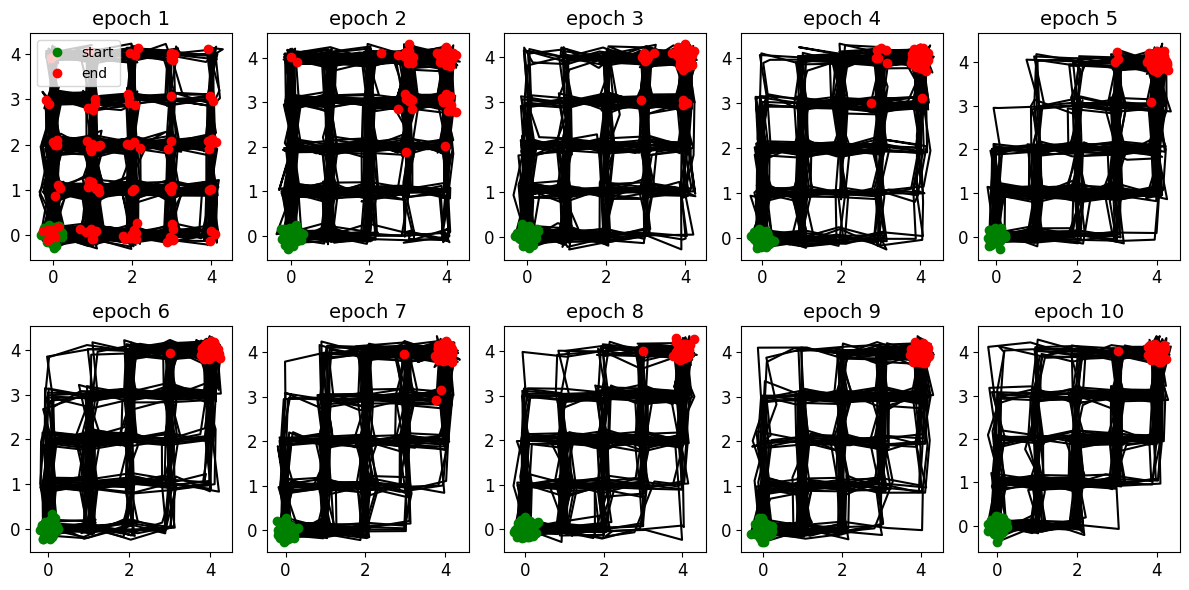

In [11]:
# sample paths to coordinates
num_eps = 10
max_eps = 10
eps_idx = np.arange(max_eps, step=max_eps // num_eps)

sample_path_coor = []
for i in eps_idx:
    sample_path_ = np.stack([env.state2pos[d] for d in sample_path[i]["s"]]).astype(float)
    sample_path_ += np.random.normal(size=(len(sample_path_), max_steps, 2)) * 0.1
    sample_path_coor.append(sample_path_)

# plot sample paths on coordinates
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flat
for i in range(len(ax)):
    ax[i].plot(sample_path_coor[i][:, :, 0].T, sample_path_coor[i][:, :, 1].T, "k-")
    ax[i].plot(sample_path_coor[i][:, 0, 0], sample_path_coor[i][:, 0, 1], "go", label="start")
    ax[i].plot(sample_path_coor[i][:, -1, 0], sample_path_coor[i][:, -1, 1], "ro", label="end")
    ax[i].set_title(f"epoch {eps_idx[i] + 1}")

ax[0].legend(loc="upper left")
plt.tight_layout()
plt.show()

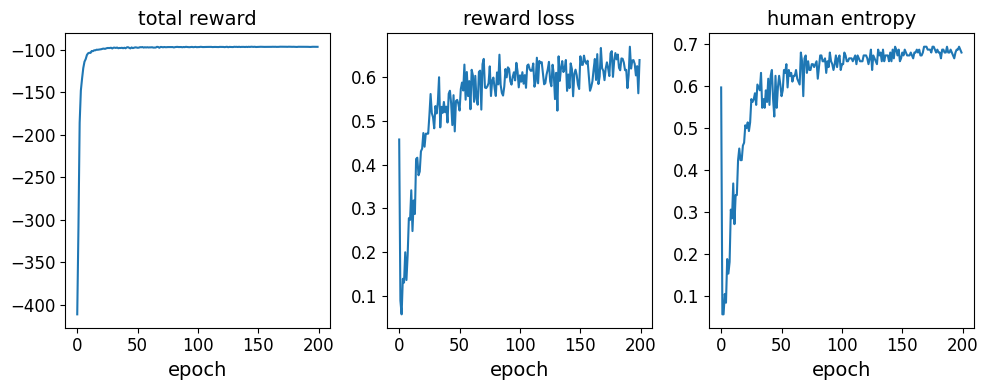

In [12]:
# plot history
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True)
ax[0].plot(history["reward"])
ax[0].set_xlabel("epoch")
ax[0].set_title("total reward")

ax[1].plot(history["loss"]) # binary cross entropy reward loss
ax[1].set_xlabel("epoch")
ax[1].set_title("reward loss")

ax[2].plot(history["entropy"]) # average human preference distribution entropy
ax[2].set_xlabel("epoch")
ax[2].set_title("human entropy")

plt.tight_layout()
plt.show()

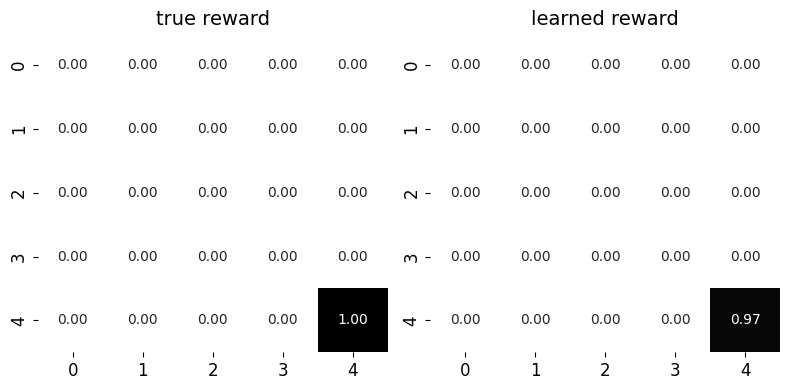

In [13]:
with torch.no_grad():
    r_true = env.value2map(env.target_dist)
    r_pred = env.value2map(agent.target_dist())

vmin, vmax = r_true.min(), r_true.max()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(r_true, fmt=".2f", vmin=vmin, vmax=vmax, annot=True, cbar=False, cmap="Greys", ax=ax[0])
sns.heatmap(r_pred, fmt=".2f", vmin=vmin, vmax=vmax, annot=True, cbar=False, cmap="Greys", ax=ax[1])

ax[0].set_title("true reward")
ax[1].set_title("learned reward")

plt.tight_layout()
plt.show()